In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

# Language Models

Language models (LMs) calculate the probability to see a given sequence of words. 

Use Cases:

* To filter out bad translations in machine translation.
* To rank speech recognition output. 
* In concept-to-text generation.

Formally a language model is a stochastic process that models the probability \\(\prob(w_1,\ldots,w_d)\\) of observing sequences of words \\(w_1,\ldots,w_d\\). 

Without loss of generality: 

$$
\prob(w_1,\ldots,w_d) = \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1}).
$$

## A Uniform Baseline LM

*Unigram* models set the conditional probability of a word to the prior probability of seeing that word:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

The simplest instantituation of a unigram model: a *uniform* language assigns the same prior probability to each in a *vocabulary* of words \\(\vocab\\):

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

Let us look at a training set and create a uniform LM from it.

In [2]:
train[:10]

['[BAR]', 'Can', "'", 't', 'even', 'call', 'this', 'a', 'blues', 'song']

In [3]:
vocab = set(train)
baseline = UniformLM(vocab)
baseline.probability("call")

0.0003912363067292645

## Sampling
* Sampling from an LM is easy and instructive
* Usually, the better the LM, the better the samples

In [4]:
sample(baseline, [], 10)

['happenin',
 'blame',
 'tell',
 'food',
 'Approximate',
 'float',
 'sets',
 'leg',
 'last',
 'Remember']

## Evaluation
* **Extrinsic**: how it improves a downstream task?
* **Intrinsic**: how good does it model language?

## Intrinsic Evaluation
* *Shannon Game*: Predict next word, win if prediction match words in actual corpus. 
* Formalised through *perplexity* of the LM on a given dataset. 

Given a test sequence \\(w_1,\ldots,w_T\\) of \\(T\\) words, perplexity \\(\perplexity\\) is:

$$
\perplexity(w_1,\ldots,w_T) = \prob(w_1,\ldots,w_T)^{-\frac{1}{T}} = \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-n},\ldots,w_{i-1})}}
$$

Perplexity of uniform LM on a test set?

In [5]:
perplexity(baseline, test)  

inf

The problem in the above example is that the baseline model assigns zero probability to words that are not in the vocabulary. 

In [6]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:3]

[('send', 0.0), ('corrections', 0.0), ('typist', 0.0)]

## The Long Tail
New words not specific to our corpus: 
* long **tail** of words that appear only a few times
* each has low probability, but probability of seeing any long tail word is high


Let us plot word frequency ranks (x-axis) against frequency (y-axis) 

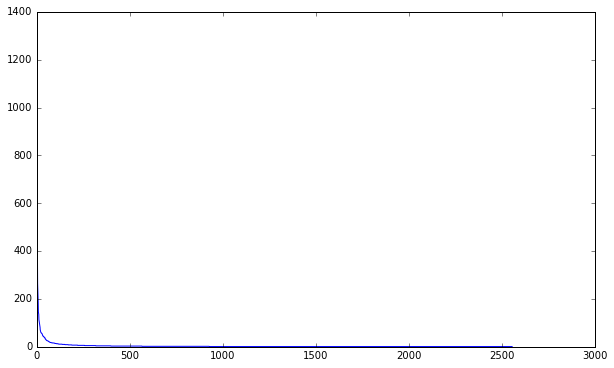

In [2]:
plt.xscale('linear')
plt.yscale('linear')
plt.plot(ranks, sorted_counts)

In log-space such rank vs frequency graphs resemble linear functions. This observation is known as **Zipf's Law**, and can be formalized as follows. Let \\(r\_w\\) be the rank of a word \\(w\\), and \\(f\_w\\) its frequency, then we have:

$$
  f_w \propto \frac{1}{r_w}.
$$


## Inserting Out-of-Vocabularly Tokens
There will always be words with zero counts in your training set.

Solutions:
* Remove unseen words from test set (bad)
* Move probability mass to unseen words (good, discuss later)
* Replace unseen words with out-of-vocabularly token, estimate its probability

In [8]:
replace_OOVs(baseline.vocab, test[:10])

['[BAR]',
 '[OOV]',
 '[OOV]',
 'to',
 'the',
 '[OOV]',
 '[/BAR]',
 '[BAR]',
 '[/BAR]',
 '[BAR]']

Heuristically estimate the `OOV` probability:
* replace the first encounter of each word in the training set with the `OOV` token
* train language model on replaced data

In [9]:
inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

In [10]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test) 

928.0000000011556

What does this perplexity correspond to?

## Training Language Models
* Uniform LM is not good at modelling language. 
* Better: estimate n-gram distributions from the training data. 
* Introduce parameter $\param_{w,h}$ for word $w$ history $h$. 
* Define a parametrized language model $p_\params$: 

$$
\prob_\params(w|h) = \param_{w,h}
$$

* Training amounts to estimating \\(\params\\) from training set \\(\train=(w_1,\ldots,w_n)\\).
* One way: choose \\(\params\\) that maximizes the log-likelihood of \\(\train\\):
$$
\params^* = \argmax_\params \log p_\params(\train)
$$

As it turns out, this maximum-log-likelihood estimate (MLE) can calculated in **closed form**:
$$
\param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

Many LM variants can be implemented by estimating the counts in the nominator and denominator differently.

## Unigram Model
Let us train a unigram model with $n=1$

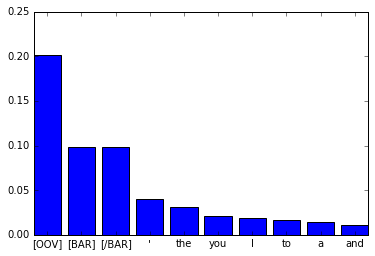

In [11]:
unigram = NGramLM(oov_train,1)
plot_probabilities(unigram)

The unigram LM has substantially reduced (and hence better) perplexity:

In [12]:
perplexity(unigram,oov_test) 

78.11302463241343

It's samples look more reasonable:

In [13]:
sample(unigram, [], 10)

['think',
 'live',
 '[/BAR]',
 'and',
 '[OOV]',
 'that',
 '[/BAR]',
 'I',
 'love',
 'Yeah']

## Bigram Model
We can do better by setting $n=2$

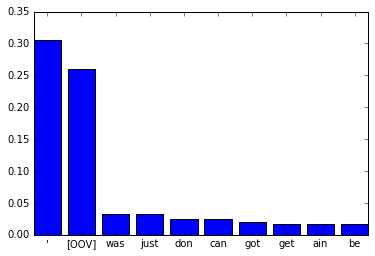

In [14]:
bigram = NGramLM(oov_train,2)
plot_probabilities(bigram, ('I',))

Samples should look (slightly) more fluent:

In [15]:
" ".join(sample(bigram, ['[BAR]'], 30))

"[BAR] [/BAR] [BAR] [OOV] and [OOV] the love to make it [/BAR] [BAR] It ' ALL PEACE Y ' [OOV] after the fuck how to [OOV] to be [/BAR] [BAR] You"

How about perplexity?

In [16]:
perplexity(bigram,oov_test) 

inf

There are contexts in which the OOV word (and other words) hasn't been seen, and hence it receives 0 probability.

In [17]:
bigram.probability("[OOV]","money") 

0.0

## Smoothing

* maximum likelhood underestimates true probability of some words, and overestimates the probabilities of other. 
* Solution: _smooth_ the probabilities and move mass from seen to unseen events.

### Laplace Smoothing

* add pseudo counts to each event in the dataset 
* Bayesian view: maximum posteriori estimate under a dirichlet prior on parameters.

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

In [18]:
laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0010660980810234541

Perplexity should look better now:

In [19]:
perplexity(laplace_bigram,oov_test) 

59.51634219903197

### Interpolation
Laplace Smoothing shifts mass uniformly across the words that haven't been seen.

In [20]:
laplace_bigram.probability('skies','skies'), laplace_bigram.probability('[/BAR]','skies')

(0.0010548523206751054, 0.0010548523206751054)

We can do better: 
* give more mass to words likely under the $n-1$-gram model. 
* Combine \\(n\\)-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n},\ldots,w_{i-1}) + \\ (1 - \alpha) \cdot \prob''(w_i|w_{i-n+1},\ldots,w_{i-1})
$$


In [21]:
interpolated = InterpolatedLM(laplace_bigram,unigram,0.01)
interpolated.probability('skies','skies'), interpolated.probability('[/BAR]','skies')

(0.0001662701118815446, 0.09764798462230231)

Can we find a good $\alpha$ parameter? Tune on some dev set!

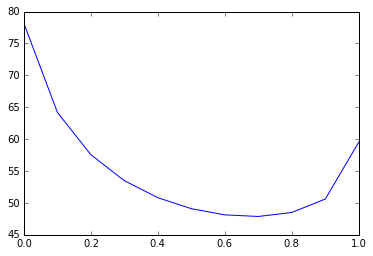

In [22]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(adjusted_laplace_bigram,unigram,alpha),oov_test) for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
* rely on available counts where possible. 
* back-off only when no counts for a given event are available.

### Stupid Backoff
Let \\(w\\) be a word and \\(h_{n}\\) an n-gram of length \\(n\\):  

$$
\prob_{\mbox{Stupid}}(w|h_n) = 
\begin{cases}
\frac{\counts{\train}{h_n,w}}{\counts{\train}{h_n}}  &= \mbox{if }\counts{\train}{h_n,w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{n-1}) & \mbox{otherwise}
\end{cases}
$$

What is the problem with this model?

In [23]:
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0711443177349613

"proper backoff models" do not have this problem, e.g. the Katz-Backoff method. See external material for a deeper discussion of these.

### Background Reading

* Jurafsky & Martin, Speech and Language Processing: Chapter 4, N-Grams.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)